<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Introduction to NLP Fundamentals in TensorFlow.

 NLP has the goal of deriving information out of natural language (could be sequence of text or words).
 Another common term for NLP problems is sequence to sequence problems (seq2seq).

In [1]:
# Check for GPU.

!nvidia-smi

Thu Mar 13 05:18:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
## Get helper functions.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-03-13 05:18:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-03-13 05:18:30 (84.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get our text dataset.

The dataset we're going to be using is Kaggle's introduction to NLP dataset(text samples of Tweets labelled as diaster or not diaster).


In [3]:
!wget  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# unzip data.
unzip_data("nlp_getting_started.zip")

--2025-03-13 05:18:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.28MB/s    in 0.5s    

2025-03-13 05:18:42 (1.28 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
# Reading the file with pandas.
import pandas as pd

train_df  = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Lets' shuffle our dataFrame.
train_df_shuffled = train_df.sample(
    frac=1,   # Frac is what percentage of the data to shuffle, 1 is equal to 100
    random_state=42
)

In [6]:
# What are the totoal number of samples.

len(train_df), len(test_df)

(7613, 3263)

In [7]:
# Let's visualize some random sample examples.
import random
random_index = random.randint(0, len(train_df)-5)    # create random indexes not higher than the totla number of samples.
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
PolicyLab is at @CECANF's last public hearing in NYC today and tomorrow to address child abuse and neglect fatalities http://t.co/n2cY3Z4TPB

---

Target: 1 (real disaster)
Text:
Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/Xum8YLcb4Q

---

Target: 0 (not real disaster)
Text:
Does this apply to Muslims/terrorism?
Or Catholicism/homophobia?

---

Target: 1 (real disaster)
Text:
Civilian Casualties in Afghanistan Reach Record High http://t.co/r8pTVFUh5X http://t.co/npCKK0tlEQ

---

Target: 1 (real disaster)
Text:
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/VTS9CAyiBC

---



## Split data into training and validation sets.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Use trian_test_split to split training data into traning and validation sets.

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1,
    random_state=42
)

In [10]:
# Check the first 10 samples.
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text to numbers.

When dealing with text problems one of the first thing we have to do before we build the model is to convert the text to numbers. There are few ways to do this.

1. Tokenization: Direct mapping of Tokenization
2. Embedding: Create a matrix of feature vector for each token.

## Text Vectorization (tokenization)

In [11]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [12]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D


# Use the default TextVectorization parameters.
text_vectorizer = TextVectorization(
    max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
    standardize="lower_and_strip_punctuation", # how to process text.
    split="whitespace", # how to split tokens
    ngrams=None, # create groups of n-words?
    output_mode="int", # how to map tokens to numbers
    output_sequence_length=None, # how long should the output sequence of tokens be?
    # pad_to_max_tokens=True
)

In [13]:
# Find the average numbers of token (words) in the traning data.
average_number_of_token = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
average_number_of_token

15

In [14]:
# Setup text vectorization variables.
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = average_number_of_token # max length our sequences will be (e.g. how many words from a Tweet does our model see?)


# recreating the intance of text_vectorization.
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [15]:
# Fit the text vectorizer to the traning text.

text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample sentence and tokenize it.
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [17]:
# Choose a random sentence from the training dataset and tokenize it.
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text:
 @kakajambori ??
U control the future of india..
Yor Subject: Exploration or seismic Maintenance( Electrical or Mechanical)        

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  142,  783,    2, 1207,    6,  544, 6547, 1960, 1680,   53,
         641, 2057, 2478,   53]])>

In [18]:
# Get the unique words in the vocabulary.
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words.
top_5_words = words_in_vocab[:5]  # get the most commmon words.
bottom_5_words = words_in_vocab[-5:]  # get the least common words.
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding layer.

To make our embedding, we're going to use Tensorflows embedding layer.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The paramters we care most about for our embedding layer:
1. 'input_dim' = Size of our input vocab.
2. 'output_dim' = Size of the output embedding vector.

example, a value of 100 would mean each token gets represented by a vector 100 long.
3. 'input_length' = length of the sequences being passed to the embedding layer.

In [19]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128,     # Neural networks works with numbers that are divible by 8.
)

embedding

<Embedding name=embedding, built=False>

In [20]:
# Get a random sentence from the training set.
random_sentence = random.choice(train_sentences)

print(f"Original text: \n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(
    text_vectorizer([random_sentence])
)

sample_embed


Original text: 
 Refugee Connections Indiegogo campaign will be going live tomorrow! Support us and help launch the only online community for #refugees.        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01236508, -0.02913135, -0.01337945, ...,  0.01215236,
         -0.00650326, -0.01871467],
        [-0.02690421,  0.00533223, -0.03367758, ..., -0.01072152,
         -0.03814455, -0.04906117],
        [-0.02690421,  0.00533223, -0.03367758, ..., -0.01072152,
         -0.03814455, -0.04906117],
        ...,
        [ 0.03927255, -0.03472244, -0.04854287, ...,  0.04682245,
          0.03293094, -0.00419886],
        [-0.02516992,  0.04587075, -0.02586601, ..., -0.00735762,
         -0.03216185,  0.02186525],
        [-0.03922345, -0.04922708, -0.01055921, ..., -0.02898671,
         -0.03452436, -0.02432834]]], dtype=float32)>

In [21]:
# Check out a single tokne's embedding.

sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-1.23650804e-02, -2.91313529e-02, -1.33794546e-02,  4.89524491e-02,
        -4.97070216e-02,  4.06310707e-03, -4.49777730e-02, -1.82688460e-02,
         2.92768143e-02,  4.68785055e-02,  4.33918275e-02, -2.14988235e-02,
        -5.24761528e-03, -4.65909131e-02, -3.89485136e-02, -1.90978535e-02,
         4.16189097e-02, -1.43809244e-03,  3.21059935e-02,  2.35301740e-02,
         2.35693529e-03,  2.50988714e-02,  2.76188515e-02,  3.02515924e-04,
        -4.59162146e-03,  5.00835106e-03,  7.60633871e-03,  3.32615413e-02,
        -1.61178038e-03, -2.84640081e-02,  4.06748392e-02,  3.37374918e-02,
         3.91276963e-02, -2.45558750e-02,  2.75467075e-02,  9.28764418e-03,
         1.06550567e-02, -8.83065537e-03,  3.70925926e-02,  2.03730725e-02,
         2.82109417e-02,  4.72652353e-02, -9.73173231e-03, -4.57738154e-02,
         3.72288115e-02,  1.54711865e-02, -2.93665007e-03,  2.08570473e-02,
        -4.15412411e-02,  3.88771780e-0

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

we'll start with a baseline and move on from there.

* Model 0: Build a Naive Bayes (baseline): https://scikit-learn.org/stable/modules/naive_bayes.html

* Model 1: Feed-forward neural network (dense model)

* Model 2: LSTM model (RNN)

* Model 3: GRU model (RNN)

* Model 4: Bidirectional_LSTM model (RNN)

* Model 5: 1D Convolutional Neural Network(CNN)

* Model 6: TensorFlow Hub Pretrained Feature extractor (using transfer learning for NLP)

* Model 7: Same as model 6 with 10% of traning data


Wei'll use the standard stpes in modelling.

* Create a model.
* Build a model
* Fit the model
* Evaluate our model.


### Model 0: Getting a baseline.

As with all ML modelling experiments, it's important to create a baseline.

We'll use Sklearn Multinomial Naive Bayes to classify our Tweets.
NB: It's always good to use Non ML Algo for baseline because of thier speed.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB   # One of the model in the Naive bayes.
from sklearn.pipeline import Pipeline


# Create Tokenization and modelling pipeline.
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),          # Convert words to numbers
    ("clf", MultinomialNB())   # Model the text.
])

# Fit the pipeline to the traning data.
model_0.fit(train_sentences, train_labels)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evalaute our baseline model.

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [24]:
# Make predictions.
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evalation function for our model experiment.

We could evaluate all of our model predictions with different metrics eveery time, howerver this is combasion and could be fixed with a function.

We will use *Accuracy, Precision, Recall and F1-score*

In [25]:

# Creating an evaluation function to evaluate our model.
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results


In [26]:
# Calling the calculated evaluation results.
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [27]:

# Turn our baseline_results into a DF.
baseline_df = pd.DataFrame(
    baseline_results,
    index=["baseline"]
)
baseline_df

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219


<Axes: >

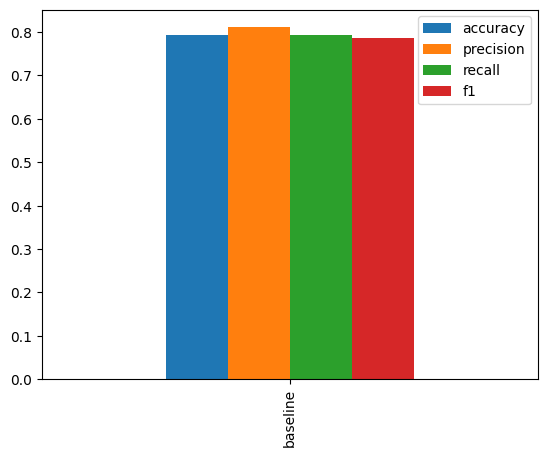

In [28]:
# Plot our baseline_df.
pd.DataFrame(baseline_df).plot.bar()

## Model 1: Feed-forward neural network (Dense model)


In [29]:
# Create a tensorboard callbac(ned to create a new one for a new model).
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs.
SAVE_DIR = "model_logs"


In [30]:

# Build model with the Functional API.
from tensorflow.keras import layers
import tensorflow as tf

inputs = layers.Input(shape=(1,), dtype=tf.string)  # inputs are 1-dimentional strings.

# Converting our string input to integers.
x = text_vectorizer(inputs)

# Create an Embedding of the numberized inputs.
x = embedding(x)

# Applying GlobalAveragePooling1D to reduce dimentionality.
x = layers.GlobalAveragePooling1D()(x)

# Create output layer. We'll use Sigmoid activation since we're dealing with Biniary.
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [31]:

# Get the summary of our model.
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:

# Compile model.
model_1.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


In [33]:

# Fit the model
model_1_history = model_1.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_1_dense")
    ]
)


Saving TensorBoard log files to: model_logs/model_1_dense/20250313-051854
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6384 - loss: 0.6488 - val_accuracy: 0.7664 - val_loss: 0.5350
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8071 - loss: 0.4754 - val_accuracy: 0.7887 - val_loss: 0.4724
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8566 - loss: 0.3637 - val_accuracy: 0.7913 - val_loss: 0.4593
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8968 - loss: 0.2819 - val_accuracy: 0.7940 - val_loss: 0.4630
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9176 - loss: 0.2323 - val_accuracy: 0.7822 - val_loss: 0.4844


In [34]:

# Get the summary.
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [35]:

# Check results.

model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7723 - loss: 0.5147


[0.484401673078537, 0.7821522355079651]

In [36]:

# Make some predictions and evaluate those.
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


(762, 1)

In [37]:
model_1_preds_probs[:10]


array([[0.3208    ],
       [0.8276681 ],
       [0.99744993],
       [0.23794526],
       [0.12131321],
       [0.9542839 ],
       [0.9249456 ],
       [0.992105  ],
       [0.96435356],
       [0.45552155]], dtype=float32)

In [38]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

NB: We can't compare our model_1_preds_probs to val_labels since our model_2_preds_probs is in the form of prob. Hence we must round on/off



In [39]:
# Convert model prediction prob to label format.
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:

# Calculate model_1 results.
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7821522309711286,
 'precision': 0.7840694582051416,
 'recall': 0.7821522309711286,
 'f1': 0.7801766074787211}

In [41]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

NB: Our baseline_results outperforms our model_1_results. This shows that not every experiment you run will improve our model performance.



## Visualizing learned embeddings.
delving deep into embeddings.

In [42]:

# Get the vocabulrary form the text vectorization layer.
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:

# Model 1 summary.
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [44]:

# Get the weight matrix of the embedding layer. They are the numerical representation of our training data which have been learned for 5 epochs.
embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights


[array([[-0.02585133, -0.04603103,  0.03088257, ..., -0.03220185,
         -0.04897776,  0.0365518 ],
        [-0.03915382, -0.00687093, -0.03850825, ...,  0.0006661 ,
         -0.04965257, -0.05980988],
        [-0.05440563, -0.06496316, -0.02262505, ..., -0.01487947,
         -0.04848468, -0.03757911],
        ...,
        [ 0.02936294,  0.04440388,  0.01936284, ..., -0.03714579,
         -0.03126259,  0.03271601],
        [-0.00996553,  0.01048592, -0.06354024, ...,  0.01886441,
         -0.06320161, -0.01087795],
        [-0.02204511, -0.09928829, -0.05847006, ...,  0.07300011,
         -0.11156498, -0.10065819]], dtype=float32)]

In [45]:

# Create embedding files. This code is gotton from doc. https://www.tensorflow.org/text/guide/word_embeddings
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# Get the total number of vectors in the embedding weights
num_vectors = embed_weights[0].shape[0]

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.

  # Only write vectors if the index is within the valid range
  if index < num_vectors:
    vec = embed_weights[0][index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
  else:
    # for safety , we are breaking when index is greater or equals num_vectors
    break
out_v.close()
out_m.close()

In [46]:

# Download files from coloab to projector.
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model 2: Recurrent Neural Networs (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

RNN's use the representation of the previous input to help the repreentation of the present.

we will use *LSTM* Long Short Term Memory

In [47]:
from tensorflow.keras import layers

# recreating the instance of text_vectorization.
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",  # Change back to "int"
    output_sequence_length=max_length  # Reinstate this
)
# Adapt the text_vectorizer before defining the wrapper layer
text_vectorizer.adapt(train_sentences)  # Call adapt here

# Now build the model without the wrapper
inputs = layers.Input(shape=(1,), name="string", dtype=tf.string)
x = text_vectorizer(inputs)  # Use text_vectorizer directly
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)  # Add another GlobalAveragePooling1D after LSTM
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# # Build the RNN's model using the Functional API model.
# from tensorflow.keras import layers
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization
# inputs = layers.Input(shape=(1,), dtype=tf.string)  # inputs are 1-dimentional strings.

# # Converting our string input to integers.
# x = text_vectorizer(inputs)

# # Create an Embedding of the numberized inputs.
# x = embedding(x)
# # print(x.shape)
# # x = layers.LSTM(64, return_sequences=True)(x)
# # print(x.shape)
# x = layers.LSTM(64)(x)
# # print(x.shape)
# # x = layers.Dense(64, activation="relu")(x)
# # print(x.shape)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


In [49]:
# Compile the LSTM.
model_2.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [50]:
# get model summmray
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ string (InputLayer)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Fit the model.
model_2_history = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20250313-051911
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9085 - loss: 0.3112 - val_accuracy: 0.7730 - val_loss: 0.5243
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9339 - loss: 0.1805 - val_accuracy: 0.7730 - val_loss: 0.5983
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9456 - loss: 0.1464 - val_accuracy: 0.7717 - val_loss: 0.7232
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9573 - loss: 0.1112 - val_accuracy: 0.7769 - val_loss: 0.7127
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9660 - loss: 0.0929 - val_accuracy: 0.7638 - val_loss: 0.9482


In [52]:
# Make predictions wM model.
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[0.04743503],
       [0.8090034 ],
       [0.99984074],
       [0.07721537],
       [0.00314642],
       [0.9999186 ],
       [0.98965645],
       [0.9999883 ],
       [0.9997502 ],
       [0.3392555 ]], dtype=float32)

In [53]:
# convert model_2 pred probs to labels.
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [55]:
# Calculate model 2 results.
model_2_results = calculate_results(y_true=val_labels, y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7637795275590551,
 'precision': 0.7645678751509686,
 'recall': 0.7637795275590551,
 'f1': 0.7620205519156683}

In [56]:
base_line_results

NameError: name 'base_line_results' is not defined

well our model_2 did not improve as per the baseline_results. We could train for more or we could add the number of hidden units.

## Model 3: Building a GRU.

Another popular and effective RNN is the GRU(Gated Recurrent Unit).

The GRU has similar features to an LSTM cell but has less parameters.

In [ ]:
from tensorflow.keras import layers

# recreating the instance of text_vectorization.
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",  # Change back to "int"
    output_sequence_length=max_length  # Reinstate this
)
# Adapt the text_vectorizer before defining the wrapper layer
text_vectorizer.adapt(train_sentences)  # Call adapt here

# Now build the model without the wrapper
inputs = layers.Input(shape=(1,), name="string", dtype=tf.string)
x = text_vectorizer(inputs)  # Use text_vectorizer directly
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)  # Add another GlobalAveragePooling1D after LSTM. only when we have return_sequences in GRU.
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Compile the model.
model_3.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# Fit the model.
model_3_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_GRU")]
)

In [ ]:
# predictions the accuracy of GRU.
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

In [ ]:
# convert model_3 preds_probs to labels.
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

In [ ]:
val_labels[:10]

In [ ]:
model_3_results = calculate_results(y_true=val_labels, y_pred=model_3_preds)
model_3_results

## Model 4: Bidirectional Model

Normal RNN's goes from left to right.
However, Bidrectional RNN's goes from left-right as well as from right-left.

In [ ]:
# Build the Bidirectional RNN in tf.

inputs = layers.Input(shape=(1,), name="string", dtype=tf.string)
x = text_vectorizer(inputs)  # Use text_vector
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# compile model_4.
model_4.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# get model summary.
model_4.summary()

In [ ]:
# fit the model.
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_Bidirectional")]
)

In [ ]:
# evaluate the model.
model_4_evaluate = model_4.evaluate(val_sentences, val_labels)
model_4_evaluate

In [ ]:
# get model accuracy.
model_4_accuracy = model_4.predict(val_sentences)
model_4_accuracy[:10]

In [ ]:
# Convert pred prods to pred labels.
model_4_preds = tf.squeeze(tf.round(model_4_accuracy))
model_4_preds[:10]

In [ ]:
val_labels[:10]

In [ ]:
# calculate results of bidrectional model.
model_4_results = calculate_results(
    y_true = val_labels,
    y_pred = model_4_preds
)
model_4_results

ohh. the bidrectional model has perform really worst.

## Model 5: Convolutional 1D Neural Network

In [ ]:
# Create our functional API model.

inputs = layers.Input(shape=(1,), name="string", dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
# compile the model.
model_5.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# fit the model.
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_Conv1D")]
)

In [ ]:
# evaluate the model.
model_5_evaluate = model_5.evaluate(val_sentences, val_labels)
model_5_evaluate

## Model 6: Convolutional Neual Networks for Text (and other types of sequences).

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

'''
Inputs (text) -> Tokenization -> Embedding -> Pooling layer -> Output(class prob)

In [ ]:
# Test out our embedding layer, Conv1D layer and output layer.

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(
    filters = 32,
    kernel_size = 5,  # looks at 5 words at a time.
    activation = "relu",
    padding = "valid"
)

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [ ]:
embedding_test

In [ ]:
# Creating our functional API for Conv1D.

inputs = layers.Input(shape=(1,), name="string", dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)   # we could use any either maxpool or average....
outputs = layers.Dense(1, activation="sigmoid")(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_Conv1D")

In [ ]:
# Compile the model.
model_6.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# Fit the model.
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_Conv1D")]
)

In [ ]:
# get model summary.
model_6.summary()

In [ ]:
# Make somepredictios with our Conv1D model.
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

In [ ]:
# convert our pred_probs to labels.
model_5_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_5_preds[:10]

In [ ]:
# evalute the model.
model_6_evaluate = model_6.evaluate(val_sentences, val_labels)
model_6_evaluate

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

our *model_6* does not produce good results. Well lets explore more using transfer learning feature extraction

## Model 6: TensorFlow Hub Feature Extraction

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence encoder

In [58]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([
    sample_sentence,
    "When you call the universal sentece encoder on a sentece, it turns it into numbers."
])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [59]:
sample_sentence

"There's a flood in my street!"